In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from embeddings import get_embedding_matrix, sentence_to_indexes
from emb_path import glove_6B_300d_path, lexvec_7B_300d_path, glove_6B_50d_path
from sklearn.metrics.pairwise import cosine_similarity
from gem import SentenceEmbedder
from utils import read_sts
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
sts_dev = read_sts('data/sts_benchmark/sts-dev.csv')
sts_test = read_sts('data/sts_benchmark/sts-test.csv')

In [3]:
sts_dev.shape, sts_test.shape

((1500, 3), (1379, 3))

In [4]:
sts_test.head()

,score,sentence1,sentence2
0,2.5,A girl is styling her hair.,A girl is brushing her hair.
1,3.6,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.
2,5.0,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.
3,4.2,A man is cutting up a cucumber.,A man is slicing a cucumber.
4,1.5,A man is playing a harp.,A man is playing a keyboard.


In [5]:
def pred(ind, sim):
    n1 = sim.shape[0] // 2
    return sim[ind, n1+ind]

In [6]:
%%time

dfs = {"(sts-dev)": sts_dev,
       "(sts-test)": sts_test}
embds = {"Glove": get_embedding_matrix(glove_6B_300d_path),
         "LexVec": get_embedding_matrix(lexvec_7B_300d_path, islexvec=True)}

CPU times: user 46.9 s, sys: 4.81 s, total: 51.7 s
Wall time: 53.6 s


In [7]:
%%time

print('Unigrams:\n\n')

for df_name, df in dfs.items():
    sentences = df.sentence1.values.tolist() + df.sentence2.values.tolist()
    for e_name, (e, v) in embds.items():
        model = SentenceEmbedder(sentences, e, v, 1)
        result, s = model.gem(sigma_power=3)
        sim = cosine_similarity(result)
        df['pred'] = df.apply(lambda row: pred(row.name, sim), axis=1)
        corr = df.corr().iloc[0, 1]
        print("{:>8} + {:<8} {:>10}: {:<10}".format('GEM', e_name, df_name, corr))
        
        result, s = model.mean_embeddings()
        sim = cosine_similarity(result)
        df['pred'] = df.apply(lambda row: pred(row.name, sim), axis=1)
        corr = df.corr().iloc[0,1]
        print("{:>8} + {:<8} {:>10}: {:<10}".format('Mean', e_name, df_name, corr))

Unigrams:


     GEM + Glove     (sts-dev): 0.7893357845629009
    Mean + Glove     (sts-dev): 0.5179574524949324
     GEM + LexVec    (sts-dev): 0.771287964898322
    Mean + LexVec    (sts-dev): 0.6663107325891194
     GEM + Glove    (sts-test): 0.6366006906456994
    Mean + Glove    (sts-test): 0.23765156814800037
     GEM + LexVec   (sts-test): 0.6392510798640161
    Mean + LexVec   (sts-test): 0.38753773055647994
CPU times: user 2min 16s, sys: 11.8 s, total: 2min 28s
Wall time: 1min 16s


In [8]:
%%time

print('Bigrams:\n\n')

sigmas = []

for df_name, df in dfs.items():
    sentences = df.sentence1.values.tolist() + df.sentence2.values.tolist()
    for e_name, (e, v) in embds.items():
        model = SentenceEmbedder(sentences, e, v, 2)
        result, s = model.gem(sigma_power=3)
        sigmas.append(s)
        sim = cosine_similarity(result)
        df['pred'] = df.apply(lambda row: pred(row.name, sim), axis=1)
        corr = df.corr().iloc[0, 1]
        print("{:>8} + {:<8} {:>10}: {:<10}".format('GEM', e_name, df_name, corr))
        
        result, s = model.mean_embeddings()
        sim = cosine_similarity(result)
        df['pred'] = df.apply(lambda row: pred(row.name, sim), axis=1)
        corr = df.corr().iloc[0,1]
        print("{:>8} + {:<8} {:>10}: {:<10}".format('Mean', e_name, df_name, corr))

Bigrams:


     GEM + Glove     (sts-dev): 0.7887874402736049
    Mean + Glove     (sts-dev): 0.5179574524949327
     GEM + LexVec    (sts-dev): 0.7774679998788352
    Mean + LexVec    (sts-dev): 0.6663107325891184
     GEM + Glove    (sts-test): 0.6342502520637187
    Mean + Glove    (sts-test): 0.2376515681480004
     GEM + LexVec   (sts-test): 0.651068923376141
    Mean + LexVec   (sts-test): 0.38753773055648
CPU times: user 49.9 s, sys: 4.26 s, total: 54.2 s
Wall time: 29.1 s


In [9]:
%%time

print('Trigrams:\n\n')

sigmas = []

for df_name, df in dfs.items():
    sentences = df.sentence1.values.tolist() + df.sentence2.values.tolist()
    for e_name, (e, v) in embds.items():
        model = SentenceEmbedder(sentences, e, v, 3)
        result, s = model.gem(sigma_power=3)
        sigmas.append(s)
        sim = cosine_similarity(result)
        df['pred'] = df.apply(lambda row: pred(row.name, sim), axis=1)
        corr = df.corr().iloc[0, 1]
        print("{:>8} + {:<8} {:>10}: {:<10}".format('GEM', e_name, df_name, corr))
        
        result, s = model.mean_embeddings()
        sim = cosine_similarity(result)
        df['pred'] = df.apply(lambda row: pred(row.name, sim), axis=1)
        corr = df.corr().iloc[0,1]
        print("{:>8} + {:<8} {:>10}: {:<10}".format('Mean', e_name, df_name, corr))

Trigrams:


     GEM + Glove     (sts-dev): 0.7835360047095884
    Mean + Glove     (sts-dev): 0.5179574524949323
     GEM + LexVec    (sts-dev): 0.7773483673539848
    Mean + LexVec    (sts-dev): 0.6663107325891182
     GEM + Glove    (sts-test): 0.6488314415098602
    Mean + Glove    (sts-test): 0.23765156814800045
     GEM + LexVec   (sts-test): 0.6538780496149204
    Mean + LexVec   (sts-test): 0.38753773055648005
CPU times: user 27.6 s, sys: 2.24 s, total: 29.8 s
Wall time: 15.9 s


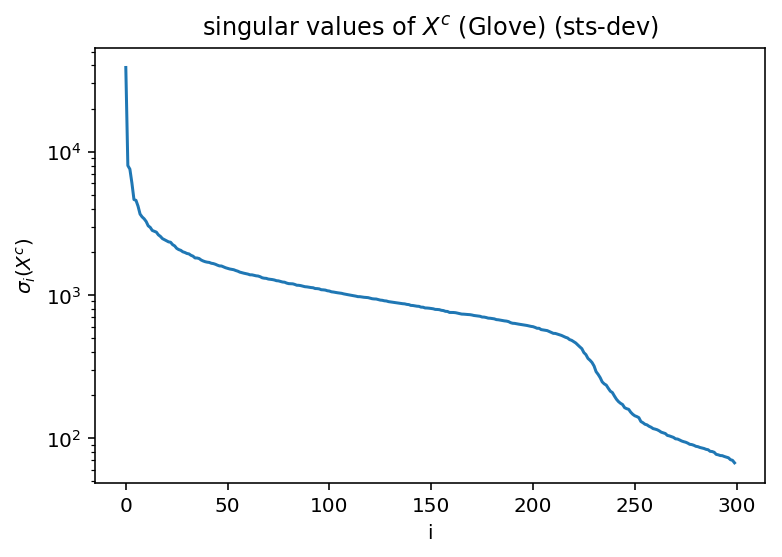

In [11]:
plt.plot(sigmas[0])
plt.yscale('log')
plt.title(r'singular values of $X^c$ (Glove) (sts-dev)')
plt.xlabel('i')
plt.ylabel(r'$\sigma_i(X^c)$')
plt.show()